# Loan approval by machine learning model

## Setup the environment and load data

In [34]:
%matplotlib inline
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import sklearn as sk
from sklearn import naive_bayes, ensemble, gaussian_process, model_selection
from IPython.display import display, Markdown

train_data = pd.read_csv('train_u6lujuX_CVtuZ9i.csv')


## Fill in missing values and convert boolean types

In [35]:
# Do not need Loan_ID
del train_data['Loan_ID']

# Fill missing values with most occuring value
train_data['Gender'] = train_data['Gender'].fillna(train_data['Gender'].value_counts().index[0])
train_data['Married'] = train_data['Married'].fillna(train_data['Married'].value_counts().index[0])
train_data['Dependents'] = train_data['Dependents'].fillna(train_data['Dependents'].value_counts().index[0])
train_data['Self_Employed'] = train_data['Self_Employed'].fillna(train_data['Self_Employed'].value_counts().index[0])
train_data['Credit_History'] = train_data['Credit_History'].fillna(0.0) # assume no credit history

# Replace yes/no features with True/False and convert dtype
train_data['Married'] = train_data['Married'].map({'Yes':True ,'No':False})
train_data['Self_Employed'] = train_data['Self_Employed'].map({'Yes':True ,'No':False})
train_data['Loan_Status'] = train_data['Loan_Status'].map({'Y':True ,'N':False})
train_data['Credit_History'] = train_data['Credit_History'].map({1.0:True ,0.0:False})

# Fill numerical type missing values with mean
train_data['LoanAmount'] = train_data['LoanAmount'].fillna(train_data['LoanAmount'].mean())
train_data['Loan_Amount_Term'] = train_data['Loan_Amount_Term'].fillna(train_data['Loan_Amount_Term'].mean())

# Convert wrongly detected float features to int
train_data['CoapplicantIncome'] = train_data['CoapplicantIncome'].astype(int)
train_data['LoanAmount'] = train_data['LoanAmount'].astype(int)
train_data['Loan_Amount_Term'] = train_data['Loan_Amount_Term'].astype(int)

# Categorize remaining fields
train_data['Gender'] = train_data['Gender'].astype('category')
train_data['Dependents'] = train_data['Dependents'].astype('category')
train_data['Education'] = train_data['Education'].astype('category')
train_data['Property_Area'] = train_data['Property_Area'].astype('category')
train_data['Loan_Amount_Term'] = train_data['Loan_Amount_Term'].astype('category')


## Descriptive graphing

### Plot numerical features to find appropriate bins

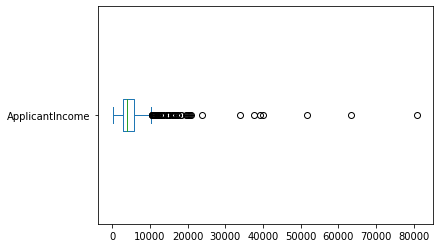

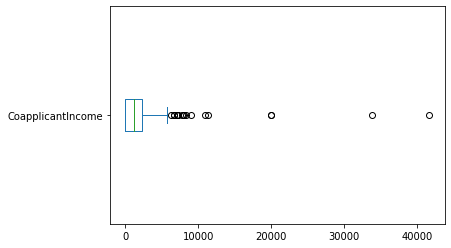

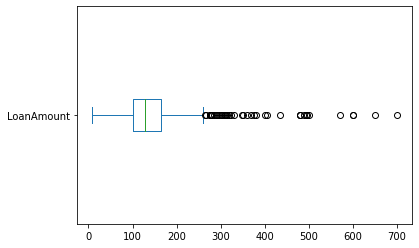

In [36]:
plt.figure(num='ApplicantIncome')
plt.tight_layout()
train_data['ApplicantIncome'].plot.box(vert=False).figure.show()
plt.figure(num='CoapplicantIncome')
train_data['CoapplicantIncome'].plot.box(vert=False).figure.show()
plt.figure(num='LoanAmount')
train_data['LoanAmount'].plot.box(vert=False).figure.show()


### Loan approval chart

<AxesSubplot:title={'center':'Loan_Status'}>

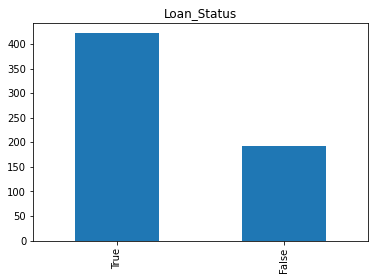

In [37]:
train_data['Loan_Status'].value_counts().plot.bar(title='Loan_Status')

### Correlation between income and loan amount

<AxesSubplot:xlabel='ApplicantIncome', ylabel='LoanAmount'>

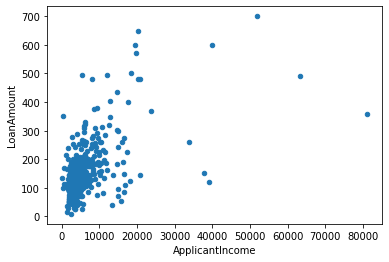

In [38]:
train_data.plot(kind='scatter', x='ApplicantIncome', y='LoanAmount')

## Categorize numerical features

In [39]:
# Use cut twice to prevent float bins and negative numbers
_, edges = pd.cut(train_data['ApplicantIncome'], 10, retbins=True)
labels = [f'({abs(edges[i]):.0f}, {edges[i+1]:.0f}]' for i in range(10)]
train_data['ApplicantIncome'] = pd.cut(train_data['ApplicantIncome'], bins=10, labels=labels)
_, edges = pd.cut(train_data['CoapplicantIncome'], 10, retbins=True)
labels = [f'({abs(edges[i]):.0f}, {edges[i+1]:.0f}]' for i in range(10)]
train_data['CoapplicantIncome'] = pd.cut(train_data['CoapplicantIncome'], bins=10, labels=labels)
_, edges = pd.cut(train_data['LoanAmount'], 7, retbins=True)
labels = [f'({abs(edges[i]):.0f}, {edges[i+1]:.0f}]' for i in range(7)]
train_data['LoanAmount'] = pd.cut(train_data['LoanAmount'], bins=7, labels=labels)


## Train algorithm

In [40]:
# Get all but last column from train_data and test_data
x = train_data.iloc[:,:-1]
# Get last column from train_data
y = train_data.iloc[:,-1:]

# Create test data from training data
x_train, x_test, y_train, y_test = sk.model_selection.train_test_split(x, y, test_size=0.25)

# Prepare categorical features for decision tree classifier
final_train = pd.get_dummies(x_train)
final_test = pd.get_dummies(x_test)

# Create model
model = sk.svm.NuSVC(probability=True, gamma='auto', cache_size=1000).fit(final_train, y_train.values.ravel())


## Algorithm efficiency on test set

In [41]:
y_pred  = model.predict(final_test)
accuracy = sk.metrics.accuracy_score(y_test, y_pred)
display(Markdown(f'**Algorithm accuracy is: {accuracy:.3f}**'))

**Algorithm accuracy is: 0.786**

## Determine loan viability of new applicant

In [42]:
# Get categories of column
def cats(name):
    return list(x_train[name].unique())

output = widgets.Output()
@interact_manual(Gender=cats('Gender'), Married=cats('Married'), Dependents=cats('Dependents'), Education=cats('Education'), 
                     Self_Employed=cats('Self_Employed'), ApplicantIncome=cats('ApplicantIncome'), CoapplicantIncome=cats('CoapplicantIncome'),
                     LoanAmount=cats('LoanAmount'), Loan_Amount_Term=cats('Loan_Amount_Term'), Credit_History=cats('Credit_History'),
                     Property_Area=cats('Property_Area'))
def get_loan_decision(Gender, Married, Dependents, Education, 
                     Self_Employed, ApplicantIncome, CoapplicantIncome,
                     LoanAmount, Loan_Amount_Term, Credit_History,
                     Property_Area):
    # Match columns of new DataFrame to what the model was trained with
    X = pd.get_dummies(pd.DataFrame(locals(), index=[0]))
    X = X.reindex(final_test.columns, axis = 1, fill_value = 0)
    
    decision = 'Approved' if model.predict(X) else 'Denied'
    return display(Markdown(f'### **Loan {decision}**'))

interactive(children=(Dropdown(description='Gender', options=('Male', 'Female'), value='Male'), Dropdown(descr…